# Cfr. Shift fit model in GCMs and Reanalyis

In [1]:
# necessary: netcdf4-python, regionmask, (xarray, geopandas), cartopy, openpyxl, statsmodels

import numpy as np
import pandas as pd
import os, glob, re 
import math
import xarray as xr
import geopandas as gpd
import regionmask as regionmask
import dask
import matplotlib.pyplot as plt
import netCDF4

%matplotlib inline

#plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from scipy.stats import norm

# import my variables settings functions from other scripts
from settings_ana import *
from functions_ana import *
from utils_ana import *
from plotscript import *

# # import other packages/modules 
# sys.path.append(os.path.join(os.environ['VSC_DATA_VO_USER'],'demographics4climate/'))
# from population_demographics import * 

sys.path.append('../dist_cov/dist_cov/')
import distributions as distributions


In [146]:
cellarea = xr.open_dataarray(os.path.join(datadirs,'geo-information/clm45_area.nc4'))
figdir = os.path.join(figdirs, 'fig_sep24')


# Fxns

In [2]:
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
import matplotlib.gridspec as gridspec

def plot_map_nAHD(data_plot,
                    ax,
                    proj=ccrs.PlateCarree(),
                    vmin = -100,
                    vmax = 200, 
                    levels = np.linspace(-100, 200, 16),
                    title_label = None,
                  title=True, 
                  skew=True,
                  
            ):

    if skew:
        cmap = LinearSegmentedColormap.from_list('new_RdBu_r', plt.get_cmap('RdBu_r')(np.linspace(0.25, 1, 192))) 
        norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
    else:
        cmap = 'RdBu_r'
    crs = ccrs.PlateCarree()
    ax.set_extent([-179.75, 179.75, -60, 90], crs=ccrs.PlateCarree())

    # plot
    plot = data_plot.plot(vmin=vmin, vmax=vmax, cmap=cmap, transform=crs, levels=levels, extend='both', add_colorbar=False, ax=ax)
    ax.coastlines(color='black', linewidth=0.8)
    if title:
        try: 
            ax.set_title(f'{data_plot.dataset.values} \n{round(data_plot.min().values, 0)}, {round(data_plot.max().values,0)}, {round(data_plot.mean().values,0)}')
        except:
            ax.set_title(f'{data_plot.model.values} \n{data_plot.min().values.round(0)}, {data_plot.max().values.round(0)}, {data_plot.mean().values.round(0)}')
    else:
        ax.set_title('')
            
    ax.set_title(title_label, loc='left',fontweight='bold')

    return plot 

# 1) Calc nAHD (shift fit) from models

In [3]:
model_years = calc_warming_periods_models(GCMs, dir_gmst_models, observed_warming_path, target_year=2023, method='ar6', match='closest', windowsize=0)[['year']]
model_years

,year
model,
CanESM5,2009
CNRM-CM6-1,2025
GFDL-ESM4,2035
IPSL-CM6A-LR,2012
MIROC6,2038
MRI-ESM2-0,2024
EC-Earth3,2017
UKESM1-0-LL,2022
MPI-ESM1-2-HR,2024


In [4]:
flags['models']='ISIMIP3b'
dirname = 'output_shift-fit' 

da_list = []

for i in range(len(GCMs)):
    GCM = GCMs[i]
    filepath = glob.glob(os.path.join('/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output', 
                                      f'output_shift-fit/forster2024/WBGT/ISIMIP3b/{GCM}/*_WBGT_params_shift_loc_mon_1901_2019.nc'))[0]
    da = xr.open_dataarray(filepath).expand_dims("dataset").assign_coords(dataset=("dataset", [GCM]))
    da_list.append(da)
    
    da_params_mod = xr.concat(da_list, dim="dataset") #loc sigma long

In [5]:
da_params_mod

# plot this to cfr with obs? 

<xarray.DataArray 'fit_params' (dataset: 10, month: 12, lat: 360, lon: 720,
                                params: 3)>
array([[[[[-2.56541812e+01, -6.38589957e-01,  6.29457830e+00],
          [-2.56556172e+01, -6.49277147e-01,  6.30100682e+00],
          [-2.56435135e+01, -7.27748910e-01,  6.29189939e+00],
          ...,
          [-2.56426722e+01, -6.57334627e-01,  6.29424479e+00],
          [-2.56223005e+01, -7.48470966e-01,  6.29212653e+00],
          [-2.56251386e+01, -7.56068780e-01,  6.29960224e+00]],

         [[-2.67648796e+01,  1.00129677e+00,  6.39906481e+00],
          [-2.67702948e+01,  9.89828158e-01,  6.39587941e+00],
          [-2.67707252e+01,  9.51983590e-01,  6.39608717e+00],
          ...,
          [-2.67519570e+01,  9.79090910e-01,  6.40879977e+00],
          [-2.67382140e+01,  9.33392878e-01,  6.39930316e+00],
          [-2.67445624e+01,  9.42521502e-01,  6.40316730e+00]],

         [[-2.83428253e+01,  3.48203052e+00,  6.65275342e+00],
          [-2.83506273e+01,  3.48942585e+00,  6.65116950e+00],
          [-2.83523067e+01,  3.48886859e+00,  6.66459866e+00],
          ...,
...
          ...,
          [-1.25149721e+01,  1.23320100e+00,  2.38042861e+00],
          [-1.25130006e+01,  1.23093237e+00,  2.37757624e+00],
          [-1.25082699e+01,  1.23301167e+00,  2.38289791e+00]],

         [[-1.32789391e+01,  2.01713073e+00,  2.45846855e+00],
          [-1.32777441e+01,  2.02095279e+00,  2.45432762e+00],
          [-1.32760997e+01,  2.01658703e+00,  2.45803290e+00],
          ...,
          [-1.32869108e+01,  2.01879346e+00,  2.45752252e+00],
          [-1.32832159e+01,  2.01835396e+00,  2.46192510e+00],
          [-1.32790949e+01,  2.01959288e+00,  2.45550381e+00]],

         [[-1.25098988e+01,  6.21610636e-01,  2.46446206e+00],
          [-1.25085391e+01,  6.16510415e-01,  2.46713660e+00],
          [-1.25097098e+01,  6.21607680e-01,  2.46482709e+00],
          ...,
          [-1.25124082e+01,  6.17155228e-01,  2.46926092e+00],
          [-1.25095892e+01,  6.19359487e-01,  2.46693010e+00],
          [-1.25107508e+01,  6.17303644e-01,  2.46839549e+00]]]]])
Coordinates:
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * params   (params) object 'b0' 'b1' 'sigma'
  * dataset  (dataset) <U13 'CanESM5' 'CNRM-CM6-1' ... 'CNRM-ESM2-1'

In [6]:
df_gmst_mod = merge_model_gmst(GCMs, dir_gmst_models)
df_gmst_mod_smo = df_gmst_mod.apply(lambda col: apply_lowess(col, df_gmst_mod.index, ntime=4))
df_gmst_mod_smo

,CanESM5,CNRM-CM6-1,GFDL-ESM4,IPSL-CM6A-LR,MIROC6,MRI-ESM2-0,EC-Earth3,UKESM1-0-LL,MPI-ESM1-2-HR,CNRM-ESM2-1
year,,,,,,,,,,
1850,0.081839,0.075265,-0.116804,-0.163789,-0.073311,0.073341,-0.082681,-0.062625,-0.005754,0.124842
1851,-0.027388,0.041693,-0.073870,-0.071802,-0.082864,0.061162,0.002303,-0.021973,0.078604,0.188433
1852,-0.087118,0.024950,-0.009374,-0.008409,-0.066935,0.019337,-0.004756,0.035597,0.199157,0.173887
1853,-0.054830,0.025412,-0.004595,0.037362,0.026333,-0.047268,-0.075239,0.064067,0.104657,0.095709
1854,-0.061384,0.024409,-0.085900,0.065928,0.191804,-0.040739,-0.128356,0.021006,0.010157,-0.000254
...,...,...,...,...,...,...,...,...,...,...
2096,6.125161,4.733954,3.435702,5.299199,3.125304,3.779781,4.628006,5.891278,3.618147,4.389936
2097,6.248846,4.811054,3.459183,5.345967,3.036804,3.785240,4.909858,5.991796,3.622728,4.476962
2098,6.367561,4.867603,3.484327,5.373768,3.152982,3.818553,4.805906,6.082378,3.681728,4.505526


In [7]:
da_gmst_mod_smo = xr.DataArray(df_gmst_mod_smo, dims=["year", "dataset"])
da_gmst_mod_smo

<xarray.DataArray (year: 251, dataset: 10)>
array([[ 8.18385606e-02,  7.52653566e-02, -1.16803937e-01, ...,
        -6.26250237e-02, -5.75406827e-03,  1.24841837e-01],
       [-2.73882100e-02,  4.16930991e-02, -7.38702660e-02, ...,
        -2.19726135e-02,  7.86039936e-02,  1.88432923e-01],
       [-8.71176935e-02,  2.49502816e-02, -9.37445239e-03, ...,
         3.55972060e-02,  1.99156863e-01,  1.73886868e-01],
       ...,
       [ 6.36756093e+00,  4.86760265e+00,  3.48432657e+00, ...,
         6.08237760e+00,  3.68172836e+00,  4.50552561e+00],
       [ 6.42160200e+00,  4.94912916e+00,  3.50987447e+00, ...,
         6.16692271e+00,  3.75405663e+00,  4.53140591e+00],
       [ 6.44054136e+00,  5.02312720e+00,  3.52502444e+00, ...,
         6.29646687e+00,  3.81341471e+00,  4.55568526e+00]])
Coordinates:
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2096 2097 2098 2099 2100
  * dataset  (dataset) object 'CanESM5' 'CNRM-CM6-1' ... 'CNRM-ESM2-1'

In [8]:
model_years

,year
model,
CanESM5,2009
CNRM-CM6-1,2025
GFDL-ESM4,2035
IPSL-CM6A-LR,2012
MIROC6,2038
MRI-ESM2-0,2024
EC-Earth3,2017
UKESM1-0-LL,2022
MPI-ESM1-2-HR,2024


In [9]:
da_years = xr.DataArray(model_years, dims=["dataset", "year"]).squeeze()
da_years

<xarray.DataArray (dataset: 10)>
array([2009, 2025, 2035, 2012, 2038, 2024, 2017, 2022, 2024, 2030],
      dtype=object)
Coordinates:
  * dataset  (dataset) object 'CanESM5' 'CNRM-CM6-1' ... 'CNRM-ESM2-1'
    year     <U4 'year'

In [11]:
da_nAHD_mod_sf, da_nAHD_mo_mod_sf, da_p0_mod_sf, da_p1_mod_sf = calc_nAHD_shift_fit(da_params_mod, threshold=28, gmst_smo=da_gmst_mod_smo,year_pres=da_years,GWI=1.3)

In [12]:
da_nAHD_mod_sf = da_nAHD_mod_sf.rename({'dataset':'model'})

## Plot SF

In [13]:
# fig, axes = plt.subplots(5,2, figsize=(10,15))

# axes = axes.flatten()

# for i, ax in enumerate(axes):
#     da_nAHD_mod_sf.isel(dataset=i).plot(ax=ax, vmax=250)

Text(0.5, 0.98, 'nAHD using shift fit on models')

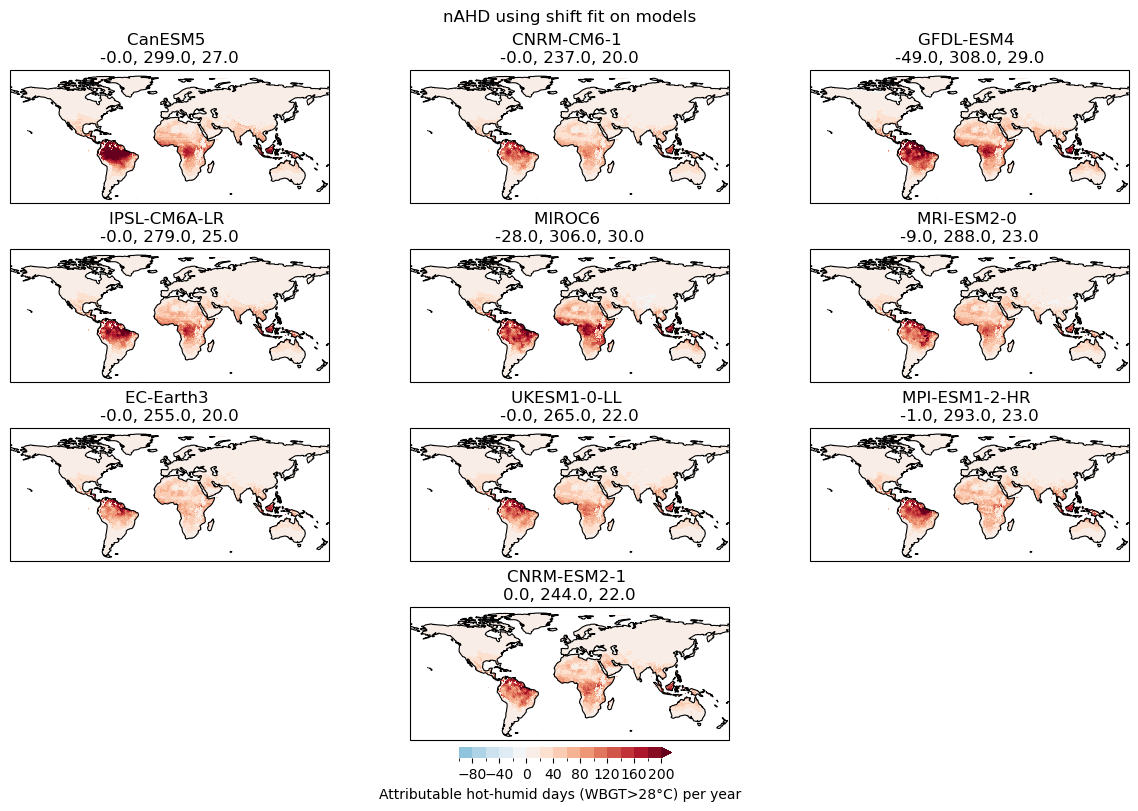

In [14]:
#import string
landmask = get_mask()

# Settings
proj = crs = ccrs.PlateCarree()
vmin, vmax, levels = -100, 200, np.linspace(-100, 200, 16) # standard in fxn 
#titles = [f"{letter}" for letter in string.ascii_lowercase[:13]]

# Create figure layout
fig = plt.figure(figsize=(12,8), layout='constrained')
gs = gridspec.GridSpec(4, 6, figure=fig)


# Plot model data
for i in range(4):
    for j in range(3):
        if i*3 + j > 8: break
        ax = fig.add_subplot(gs[i, j*2:j*2+2], projection=proj)
        data_plot = da_nAHD_mod_sf.isel(model=i*3+j) * landmask
        plot_map_nAHD(data_plot,
                  ax, 
                  #title_label=titles[3 + (i-1)*3 + j],
                     )

# Extra model subplot
ax = fig.add_subplot(gs[3, 2:4], projection=proj)
data_plot = da_nAHD_mod_sf.isel(model=9) * landmask
plot = plot_map_nAHD(data_plot,
                  ax,
                  #title_label=titles[-1],
             )

# Colorbar
cbar = fig.colorbar(plot, extend='max', ax=ax, location='bottom', shrink=1, fraction=0.08)
cbar.set_label('Attributable hot-humid days (WBGT>28°C) per year', )
cbar.outline.set_edgecolor('none')

fig.suptitle('nAHD using shift fit on models');

# 2) Compare nAHD from models using emp. pctl vs. using shift fit

## Open EP data from models 

In [15]:
dirname='output_empirical'
models='ISIMIP3b'

year=2023

da_nAHD_mod_emp = open_all_nAHD(GCMs,  metric='WBGT28', outdirname=dirname, year_pres=year)

## Plot difference

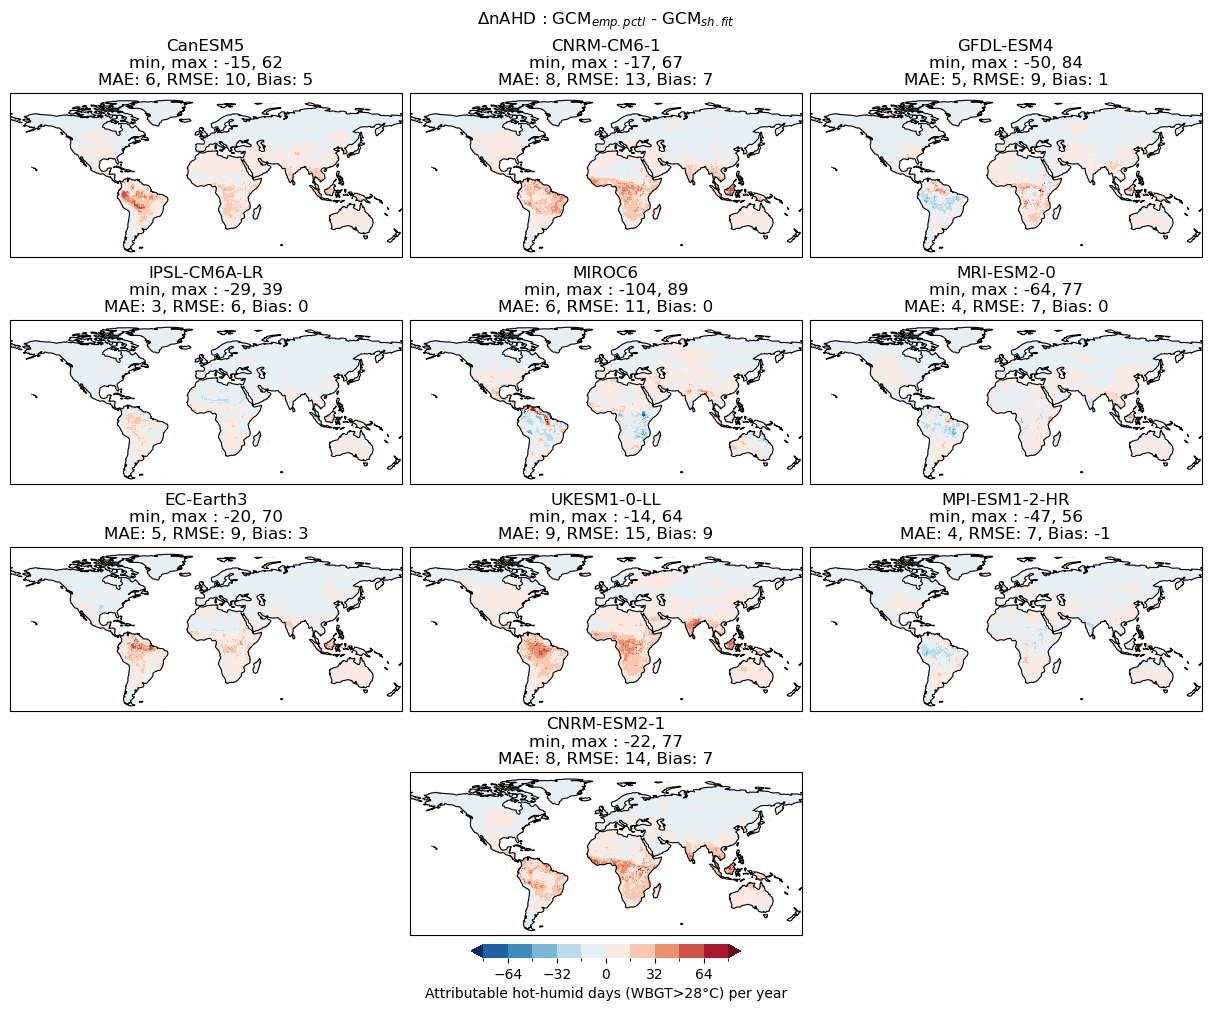

In [90]:
#import string
landmask = get_mask()

# Settings
proj = crs = ccrs.PlateCarree()
vmin, vmax = -80,80
levels = np.linspace(vmin, vmax, 11) # standard in fxn 

# Create figure layout
fig = plt.figure(figsize=(12,10), layout='constrained')
gs = gridspec.GridSpec(4, 6, figure=fig)



# Plot model data
for i in range(4):
    for j in range(3):
        if i*3 + j > 8: break
        ax = fig.add_subplot(gs[i, j*2:j*2+2], projection=proj)
        data1=da_nAHD_mod_emp.isel(model=i*3+j)
        data2=da_nAHD_mod_sf.isel(model=i*3+j)
        data_plot = ( data1 - data2 ) * landmask
        plot_map_nAHD(data_plot,
                  ax, vmin=vmin, vmax=vmax, levels=levels, skew=False
                     )
        ax.set_title(
            f"{data_plot.model.values}\n"
            f"min, max : {int(data_plot.min().values.round(0))}, {int(data_plot.max().values.round(0))}\n"
            f"MAE: {int(mae_weighted(data1, data2).values.round(0))}, "
            f"RMSE: {int(rmse_weighted(data1, data2).values.round(0))}, "
            f"Bias: {int(bias_weighted(data1, data2).values.round(0))}"
        )

# Extra model subplot
ax = fig.add_subplot(gs[3, 2:4], projection=proj)
data1=da_nAHD_mod_emp.isel(model=9)
data2=da_nAHD_mod_sf.isel(model=9)
data_plot = ( data1  - data2) * landmask
plot = plot_map_nAHD(data_plot,
                  ax, vmin=vmin, vmax=vmax, levels=levels, skew=False
             )
ax.set_title(
    f"{data_plot.model.values}\n"
    f"min, max : {int(data_plot.min().values.round(0))}, {int(data_plot.max().values.round(0))}\n"
    f"MAE: {int(mae_weighted(data1, data2).values.round(0))}, "
    f"RMSE: {int(rmse_weighted(data1, data2).values.round(0))}, "
    f"Bias: {int(bias_weighted(data1, data2).values.round(0))}"
)
# Colorbar
cbar = fig.colorbar(plot, ax=ax, location='bottom', shrink=1, fraction=0.08)
cbar.set_label('Attributable hot-humid days (WBGT>28°C) per year', )
cbar.outline.set_edgecolor('none')

fig.suptitle('$\Delta$nAHD : GCM$_{emp. pctl}$ - GCM$_{sh. fit}$');

## Notes 

Difference maps: some models show low, non-systematic bias between the two methods. In some models, EP shows a higher attributable signal, in particular in lower latitudes (SSA, N South America, Indonesia). In particular, UKESM, CNRM (2 versions) and CanESM show greatest difference between EP and SF across all continents, while EC Earth shows difference in Amazon and GFDL in Africa. 

To do : print some summary values : area weighted mean, RMSE, MAE etc.per model 

## Summary figures

In [82]:
import numpy as np

def rmse_weighted(a, b, cellarea=cellarea, mask=True):
    """
    Calculates RMSE between a forecast, a, and an observation, b, 
    with area weighting using cellarea.
    """
    if mask:
        cellarea = cellarea * landmask
        a = a * landmask
        b = b * landmask 
    weighted_squared_errors = cellarea * (a - b) ** 2
    return np.sqrt(np.sum(weighted_squared_errors) / np.sum(cellarea))

def mae_weighted(a, b, cellarea=cellarea, mask=True):
    """
    Calculates mean absolute error between a and b, 
    with area weighting using cellarea.
    """
    if mask:
        cellarea = cellarea * landmask
        a = a * landmask
        b = b * landmask 
    weighted_absolute_errors = cellarea * np.abs(a - b)
    return np.sum(weighted_absolute_errors) / np.sum(cellarea)

def bias_weighted(a, b, cellarea=cellarea, mask=True):
    """
    Calculates mean bias between a and b, 
    with area weighting using cellarea.
    """
    if mask:
        cellarea = cellarea * landmask
        a = a * landmask
        b = b * landmask 
    weighted_errors = cellarea * (a - b)
    return np.sum(weighted_errors) / np.sum(cellarea)


In [ ]:
def rmse(a,b):
    """
    calculates RMSE between a forecast, a, and an observation, b

    """
    return(np.sqrt(np.mean((a - b)**2)))

def mae(a, b):
    """
    Calculates mean absolute error between a and b, 
    """
    return np.mean(np.abs(a - b))

def bias(a, b):
    """
    Calculates mean absolute error between a and b, 
    """
    return np.mean(a - b)

def skewness(x):
    """
    Calculate skewness of x (1-D array).
    """
    return np.mean(((x - np.mean(x))/np.std(x))**3)

In [64]:
rmse_weighted(da_nAHD_mod_emp.isel(model=9), da_nAHD_mod_sf.isel(model=9), cellarea)

<xarray.DataArray ()>
array(13.92186512)
Coordinates:
    model    <U13 'CNRM-ESM2-1'

In [65]:
mae_weighted(da_nAHD_mod_emp.isel(model=9), da_nAHD_mod_sf.isel(model=9), cellarea)

<xarray.DataArray ()>
array(7.87723725)
Coordinates:
    model    <U13 'CNRM-ESM2-1'

In [66]:
bias_weighted(da_nAHD_mod_emp.isel(model=9), da_nAHD_mod_sf.isel(model=9), cellarea)

<xarray.DataArray ()>
array(7.0573251)
Coordinates:
    model    <U13 'CNRM-ESM2-1'

# 3) plot distribution of bias and scatterplot

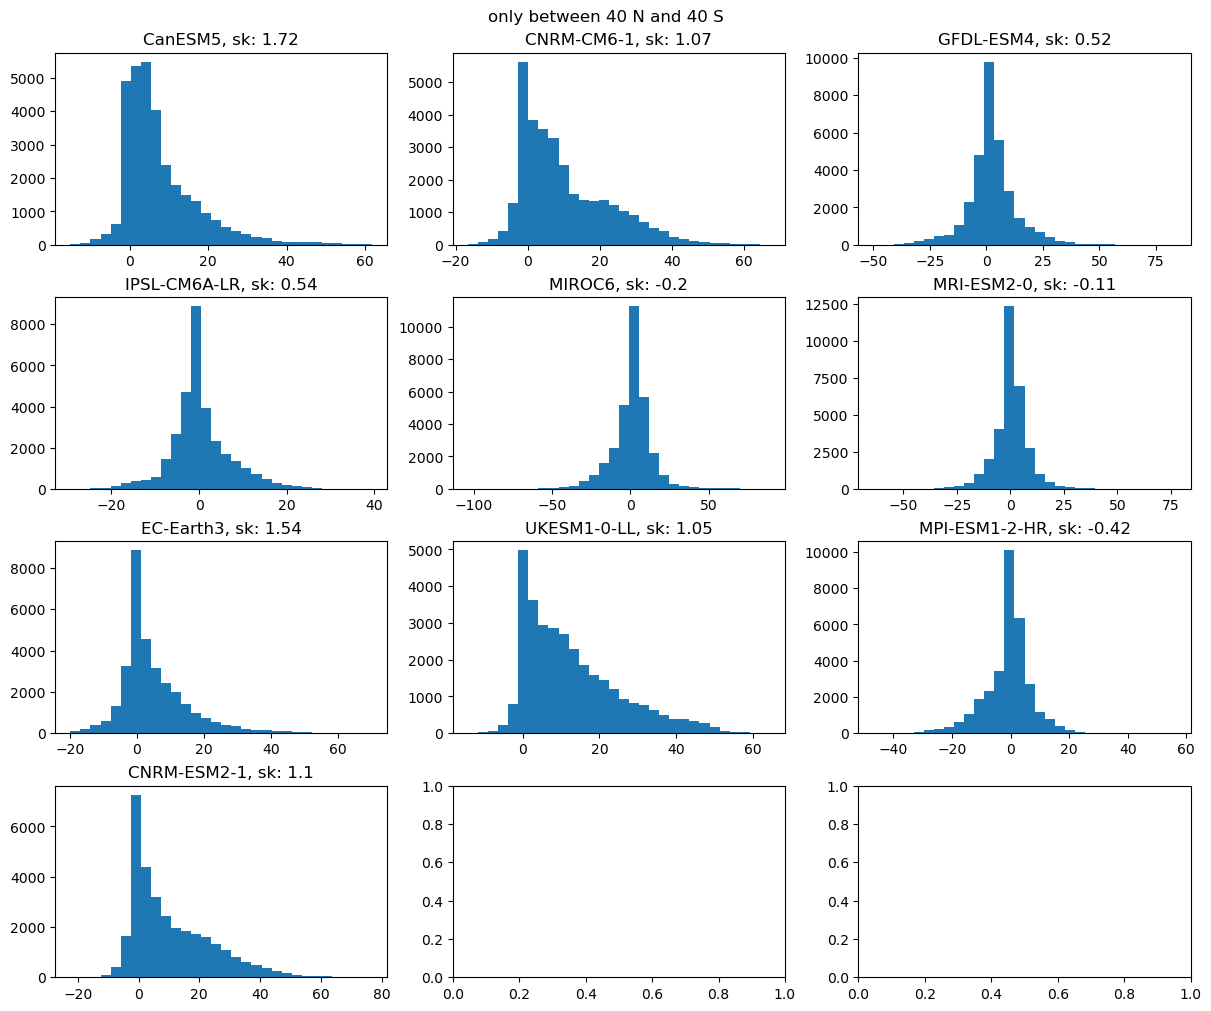

In [17]:
from scipy.stats import skew

fig, axes = plt.subplots(4,3, figsize=(12,10), layout='constrained')

axes = axes.flatten()

for i, ax in enumerate(axes):
    if i > 9: break
    data_plot = ( da_nAHD_mod_emp.isel(model=i) - da_nAHD_mod_sf.isel(model=i) ).sel(lat=slice(40,-40)) * landmask
    data_skew = skew(data_plot.values.flatten(),nan_policy='omit')

    data_plot.plot.hist(ax=ax, bins=30)
    ax.set_title(f'{data_plot.model.values}, sk: {round(data_skew,2)}')



fig.suptitle('only between 40 N and 40 S');

#Fisher-Pearson coefficient of skewness https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skew.html

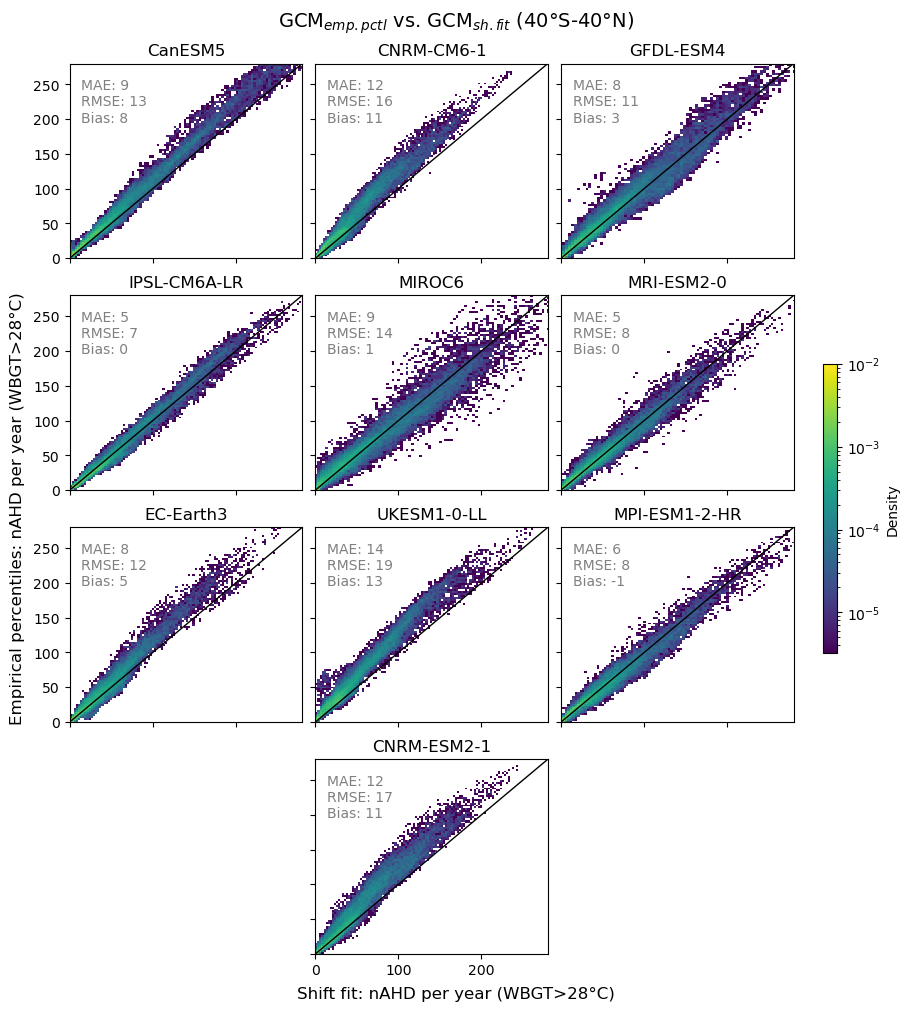

In [150]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors

fig, axes = plt.subplots(4, 3, figsize=(9, 10), constrained_layout=True, sharex=True, sharey=True)
axes = axes.flatten()
vmax = .01

# Collect all histograms for shared colorbar scaling
hist_data = []

cellarea_sel = cellarea.sel(lat=slice(40, -40))

# Plot data on the first 10 axes, ignore the last two
for i, ax in enumerate( np.concatenate((axes[:len(GCMs)-1], [axes[-2]])) ):
    if i >= 10:
        break
    data1 = da_nAHD_mod_sf.isel(model=i).sel(lat=slice(40, -40)) * landmask
    data2 = da_nAHD_mod_emp.isel(model=i).sel(lat=slice(40, -40)) * landmask
    
    x = data1.values.flatten()
    y = data2.values.flatten()
    xy = np.column_stack([x, y])
    xy = xy[~np.isnan(xy).any(axis=1)]
    
    h = ax.hist2d(xy[:, 0], xy[:, 1], bins=100, density=True, norm=colors.LogNorm(vmax=vmax) )
    hist_data.append(h[3])  # Store the mappable object for colorbar scaling

    ax.axline((0, 0), slope=1, color='k', linewidth=1)
    ax.set_title(f'{da_nAHD_mod_emp.isel(model=i).model.values.item()}')
    ax.set_ylim([0,280])
    ax.set_xlim([0,280])
    ax.text(.05,.7, 
            f"MAE: {int(mae_weighted(data2, data1, cellarea_sel ).values.round(0))}\n"
            f"RMSE: {int(rmse_weighted(data2, data1, cellarea_sel).values.round(0))}\n"
            f"Bias: {int(bias_weighted(data2, data1, cellarea_sel).values.round(0))}" ,
            transform=ax.transAxes,
            c='gray')

# Add a single colorbar shared across all subplots
cbar = fig.colorbar(hist_data[0], ax=axes[:len(GCMs)], orientation="vertical", fraction=0.02, pad=0.04)
cbar.set_label('Density')

# Remove the two empty subplots
for ax in (axes[-3], axes[-1]):
    ax.remove()

fig.suptitle('GCM$_{emp. pctl}$ vs. GCM$_{sh. fit}$ (40°S-40°N)',fontsize=14)
fig.supxlabel('Shift fit: nAHD per year (WBGT>28°C)')
fig.supylabel('Empirical percentiles: nAHD per year (WBGT>28°C) ');


# plt.savefig(os.path.join(figdir,'figSI_modeleval_sf_ep.pdf'),dpi=300,transparent=True)
# plt.savefig(os.path.join(figdir,'figSI_modeleval_sf_ep.png'),dpi=300,transparent=True)



Comparing model results using empirical percentiles vs. using shift fit on models, agreement is not bad. In some models, bias is low and centered on zero, suggesting the two methods give similar results given the same data. In other models, the bias is right-skewed, with empirical percentiles giving larger nAHD values. This suggests the shift fit method could underestimate the attributable signal. But this is not the case across all models thus seems not to be totally systematic. 

Note: could plot nAHD or the bias against the p0/p1 rarity of the day? Idk. 


To do: calc RMSE !! MAE


# Plot difference with reanalysis datasets and scatterplot of points? 

do RMSE some other eval metrics

comapare isimip3ab modelseval script, see how different they are comparing models v. obs with 2 methods on models 

Some summary stats !! 